# **Problem 2 : FGSM Based Attacks**

## Create Dataset

In [ ]:
#download imagenet dataset
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
import torch
import torchvision as tv
from torchvision import datasets,transforms
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import os

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#to import your own dataset, move it to the files in notebook and name the file image_dataset
folder = 'image_dataset'
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

def dataset(folder):
  imgset = []
  for file in os.listdir(folder):
    img = Image.open(os.path.join(folder, file))
    
    tensor = preprocess(img)
    batch = tensor.unsqueeze(0)
    batch.to(device)

    imgset.append([img,batch])
  return imgset

imgset = dataset(folder)

--2021-03-08 15:44:08--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-03-08 15:44:08 (59.3 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



## Build Models

In [ ]:
ResNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
MobileNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
VGG19_model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
#to view evals remove semicolons
def setuptmodel(model):
  model.to(device)
  model.eval()
  return

setuptmodel(ResNet_model);
setuptmodel(AlexNet_model);
setuptmodel(MobileNet_model);
setuptmodel(VGG19_model);

In [ ]:
def pred(model,batch):
  pred = []
  with torch.no_grad():
    output = model(batch)
  prob = torch.nn.functional.softmax(output[0], dim=0)
  with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    top5_prob, top5_catid = torch.topk(prob, 5)
  for i in range(top5_prob.size(0)):
    pred.append([categories[top5_catid[i]], top5_prob[i].item()])
  return pred

def printpred(pred):
  for id,prob in pred:
    print(id,prob)
  return

## Pre-Attack Predictions

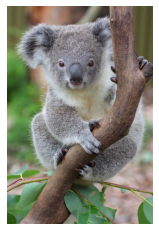

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[koala, 0.9999825954437256]","[koala, 0.9999122619628906]","[koala, 0.9999594688415527]","[koala, 1.0]"
1,"[indri, 9.078130460693501e-06]","[wallaby, 7.480315980501473e-05]","[Madagascar cat, 2.0140958440606482e-05]","[Madagascar cat, 1.4374721857279837e-08]"
2,"[Madagascar cat, 3.892509539582534e-06]","[wombat, 4.051761152368272e-06]","[indri, 1.004369551083073e-05]","[wombat, 1.3817753607980876e-09]"
3,"[wallaby, 2.638283604028402e-06]","[mongoose, 2.4082248728518607e-06]","[titi, 3.813920557149686e-06]","[indri, 2.0234117159567688e-10]"
4,"[fox squirrel, 7.804398478583607e-07]","[indri, 2.0492948351602536e-06]","[wallaby, 3.384361207281472e-06]","[wallaby, 1.722928570646598e-11]"


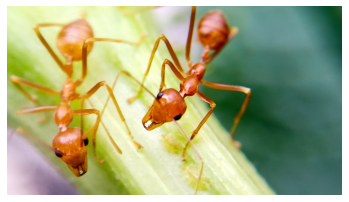

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[ant, 0.9963010549545288]","[ant, 0.852389395236969]","[ant, 0.9610707759857178]","[ant, 0.9999518394470215]"
1,"[harvestman, 0.001594727742485702]","[mantis, 0.06280826032161713]","[mantis, 0.010933732613921165]","[ground beetle, 2.7777139621321112e-05]"
2,"[mantis, 0.0006157905445434153]","[long-horned beetle, 0.04925346374511719]","[cricket, 0.01029581855982542]","[long-horned beetle, 8.987540240923408e-06]"
3,"[cricket, 0.0004279064596630633]","[walking stick, 0.01301295030862093]","[walking stick, 0.005654581822454929]","[tiger beetle, 5.190915089769987e-06]"
4,"[leaf beetle, 0.00029440506477840245]","[barn spider, 0.004564256872981787]","[harvestman, 0.004338446073234081]","[leaf beetle, 1.4827554650764796e-06]"


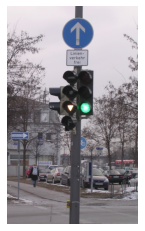

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[traffic light, 0.9999823570251465]","[traffic light, 0.9992830157279968]","[traffic light, 0.9999998807907104]","[traffic light, 0.9989455342292786]"
1,"[street sign, 1.652097125770524e-05]","[street sign, 0.0004211791092529893]","[street sign, 1.571769416841562e-07]","[street sign, 0.0009903934551402926]"
2,"[parking meter, 1.0870128335227491e-06]","[parking meter, 9.221430809702724e-05]","[totem pole, 1.8182166883207174e-08]","[parking meter, 5.822586172143929e-05]"
3,"[totem pole, 8.261356043703927e-08]","[unicycle, 3.6933648516424e-05]","[parking meter, 1.3165597501085813e-08]","[pay-phone, 2.2904478100826964e-06]"
4,"[spotlight, 5.130646574258435e-09]","[bell cote, 2.0887180653517134e-05]","[pole, 3.6361952338026526e-10]","[loudspeaker, 9.472953479416901e-07]"


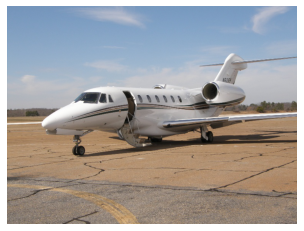

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[airliner, 0.46288564801216125]","[airliner, 0.5292186141014099]","[airliner, 0.566271185874939]","[airliner, 0.6938756108283997]"
1,"[warplane, 0.39424586296081543]","[space shuttle, 0.20786216855049133]","[warplane, 0.27722465991973877]","[wing, 0.26019492745399475]"
2,"[wing, 0.07846750319004059]","[warplane, 0.15560883283615112]","[wing, 0.13455046713352203]","[warplane, 0.0368708074092865]"
3,"[space shuttle, 0.04990866780281067]","[wing, 0.08529946953058243]","[space shuttle, 0.01971914805471897]","[space shuttle, 0.004473678767681122]"
4,"[aircraft carrier, 0.00589968403801322]","[projectile, 0.012499031610786915]","[projectile, 0.0009964737109839916]","[missile, 0.0017825908726081252]"


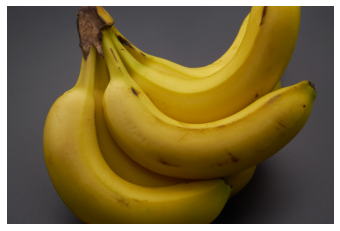

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[banana, 0.9997491240501404]","[banana, 0.9762538075447083]","[banana, 0.999863862991333]","[banana, 0.9976887702941895]"
1,"[eel, 4.6424414904322475e-05]","[mortar, 0.010868756100535393]","[lemon, 3.5489363654050976e-05]","[pitcher, 0.00033825484570115805]"
2,"[mortar, 1.8749198716250248e-05]","[potter's wheel, 0.00225233007222414]","[orange, 2.6855333999264985e-05]","[clog, 0.00019903892825823277]"
3,"[orange, 1.6172734831343405e-05]","[teapot, 0.0019079233752563596]","[pineapple, 1.1318099495838396e-05]","[mortar, 0.00018660211935639381]"
4,"[pineapple, 1.329684801021358e-05]","[lemon, 0.0013327507767826319]","[clog, 6.054266123101115e-06]","[lemon, 0.00017445074627175927]"


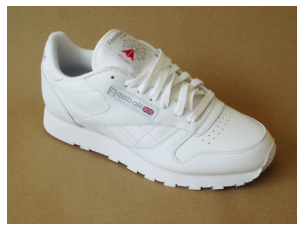

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[running shoe, 0.9998822212219238]","[running shoe, 0.9684334993362427]","[running shoe, 0.9965356588363647]","[running shoe, 0.9966230392456055]"
1,"[shoe shop, 7.04233898431994e-05]","[bib, 0.007583914324641228]","[clog, 0.002944745123386383]","[shoe shop, 0.003182298270985484]"
2,"[sandal, 3.0993101972853765e-05]","[plastic bag, 0.004866831470280886]","[sandal, 0.00031793300877325237]","[sandal, 0.00018146158254239708]"
3,"[clog, 1.3969686733616982e-05]","[toilet tissue, 0.0034364263992756605]","[shoe shop, 0.00010912554716924205]","[clog, 8.246703146141954e-06]"
4,"[Loafer, 1.5524626633123262e-06]","[handkerchief, 0.002700486220419407]","[Loafer, 6.350611511152238e-05]","[Loafer, 4.790491402673069e-06]"


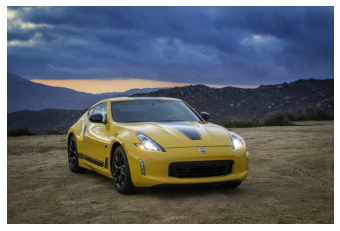

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[sports car, 0.8340631127357483]","[sports car, 0.5871646404266357]","[sports car, 0.8611714243888855]","[sports car, 0.8980594277381897]"
1,"[minivan, 0.04213791340589523]","[cab, 0.14440281689167023]","[convertible, 0.043547146022319794]","[car wheel, 0.0381740927696228]"
2,"[convertible, 0.036179881542921066]","[convertible, 0.12880152463912964]","[grille, 0.032694969326257706]","[convertible, 0.036055613309144974]"
3,"[car wheel, 0.033723678439855576]","[car wheel, 0.0435149148106575]","[racer, 0.02870188280940056]","[grille, 0.018357645720243454]"
4,"[grille, 0.019772617146372795]","[racer, 0.028352662920951843]","[car wheel, 0.024107597768306732]","[racer, 0.007053205277770758]"


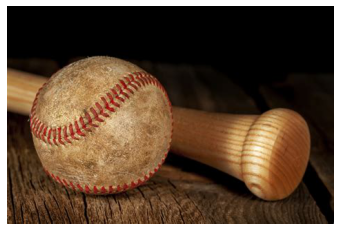

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[baseball, 0.9999146461486816]","[baseball, 0.9982439279556274]","[baseball, 0.9984982013702393]","[baseball, 0.9993698000907898]"
1,"[sombrero, 3.8663612940581515e-05]","[sombrero, 0.001518834731541574]","[maraca, 0.0013661321718245745]","[maraca, 0.000265246257185936]"
2,"[clog, 8.409808287979104e-06]","[cowboy hat, 0.00017642455350141972]","[sombrero, 7.304046448552981e-05]","[sombrero, 0.0001413396530551836]"
3,"[maraca, 6.886781648063334e-06]","[maraca, 2.8616397685254924e-05]","[drum, 1.93195683095837e-05]","[drum, 7.457508763764054e-05]"
4,"[rugby ball, 6.028047664585756e-06]","[teddy, 6.230657618289115e-06]","[tennis ball, 1.8884202290792018e-05]","[rugby ball, 4.576560604618862e-05]"


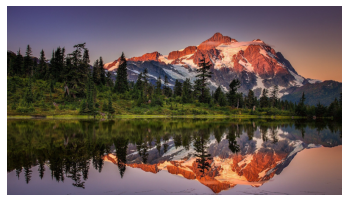

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[alp, 0.37206071615219116]","[lakeside, 0.2134188860654831]","[alp, 0.6323731541633606]","[alp, 0.2960447072982788]"
1,"[valley, 0.29740282893180847]","[valley, 0.10820350795984268]","[valley, 0.19740019738674164]","[valley, 0.26823189854621887]"
2,"[lakeside, 0.08217810839414597]","[alp, 0.10635289549827576]","[cliff, 0.03361451253294945]","[volcano, 0.18631140887737274]"
3,"[volcano, 0.08047213405370712]","[castle, 0.09193416684865952]","[lakeside, 0.025518272072076797]","[lakeside, 0.11349684000015259]"
4,"[American alligator, 0.05347844958305359]","[canoe, 0.08879991620779037]","[mountain tent, 0.01896398514509201]","[cliff, 0.04685036838054657]"


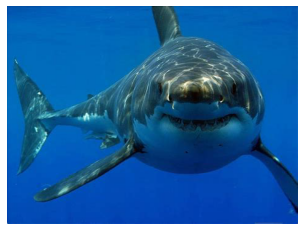

,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,"[great white shark, 0.9878068566322327]","[great white shark, 0.999340832233429]","[great white shark, 0.9875776767730713]","[great white shark, 0.9990440011024475]"
1,"[tiger shark, 0.011392042972147465]","[tiger shark, 0.00037626849371008575]","[tiger shark, 0.00943328719586134]","[tiger shark, 0.0008058089879341424]"
2,"[hammerhead, 0.0005875974893569946]","[dugong, 9.009987115859985e-05]","[hammerhead, 0.0028641726821660995]","[hammerhead, 0.0001212491697515361]"
3,"[killer whale, 0.00018674653256312013]","[killer whale, 4.190540494164452e-05]","[sea lion, 3.9322927477769554e-05]","[killer whale, 2.3615230020368472e-05]"
4,"[electric ray, 5.39695383849903e-06]","[loggerhead, 3.745194771909155e-05]","[loggerhead, 2.195176602981519e-05]","[grey whale, 2.916596258728532e-06]"


In [ ]:
initrespred = []
initalexpred = []
initmobilepred = []
initvggpred = []
for img,batch in imgset:
  plt.imshow(img)
  plt.grid('off')
  plt.axis('off')
  plt.show()
  
  #save top prediction for later analysis
  respred = pred(ResNet_model,batch)
  alexpred = pred(AlexNet_model,batch)
  mobilepred = pred(MobileNet_model,batch)
  vggpred = pred(VGG19_model,batch)

  initrespred.append(respred[0])
  initalexpred.append(alexpred[0])
  initmobilepred.append(mobilepred[0])
  initvggpred.append(vggpred[0])
  df = pd.DataFrame({
                     'ResNet-18 Model' : respred,
                     'AlexNet Model' : alexpred,
                     'MobileNet Model' : mobilepred,
                     'VGG-19 Model' : vggpred

  })
  display(df)

Attack Models

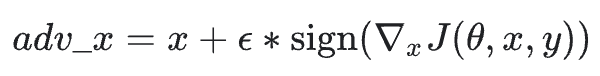

In [ ]:
from __future__ import print_function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

def convert(seconds): 
    min, sec = divmod(seconds, 60)
    return "%02d:%02d" % (min, sec)

def FGSM(x,epsilon,grad):
  sign = grad.sign()
  adv = x + epsilon*sign
  return torch.clamp(adv,0,1)

def attk(model,device,dataset,target,epsilon):
  adv_ex = []
  acc = 0
  ti= time.time()
  target = torch.tensor([target]).to(device)
  for img,data in dataset:
    data = data.to(device)
    data.requires_grad = True
    #get initial prediction
    output = model(data)
    ipred = output.max(1, keepdim=True)[1]
    #calculate loss for data gradiant
    loss = F.nll_loss(output,target)
    model.zero_grad()
    loss.backward()
    grad = data.grad.data
    #perturb the image
    adv_x = FGSM(data,epsilon,grad)
    output = model(adv_x)
    adv_ex.append(adv_x)
    #get the accuracy
    fpred = output.max(1, keepdim=True)[1]
    if fpred.item()==ipred.item():
      acc+=1
  return adv_ex,acc/len(dataset),time.time()-ti

def attack(model):
  probset = []
  time = 0
  accuracy = []
  for epsilon in epsilons:
    probs = []
    adv_ex,acc,t = attk(model,device,imgset,target,epsilon)
    accuracy.append(acc)
    time+=t
    for adv_x in adv_ex:
      probs.append(pred(model,adv_x)[0])
    probset.append(probs)
  #print total time
  print("Total Time: {}".format(convert(time)))
  #plot the accuracy graph
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracy, "*-")
  plt.yticks(np.arange(0, 1.1, step=0.1))
  plt.xticks(np.arange(0, .35, step=0.05))
  plt.title("Accuracy vs Epsilon")
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  return probset

In [ ]:
#Change these variables to examine different results
epsilons = [0,0.05,0.1,0.15,0.2,0.25,0.3]
target = 908

ResNet-18 Model Attack Results:
Total Time: 00:25


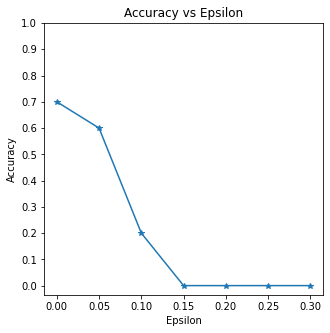

In [ ]:
print("ResNet-18 Model Attack Results:")
ResNet_probset = attack(ResNet_model)

AlexNet Model Attack Results:
Total Time: 00:22


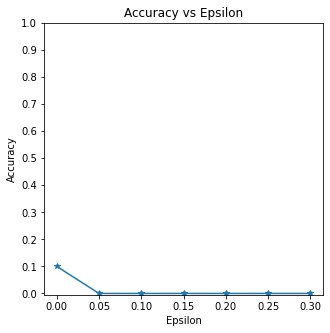

In [ ]:
print("AlexNet Model Attack Results:")
AlexNet_probset = attack(AlexNet_model)

MobileNet Model Attack Results:
Total Time: 00:21


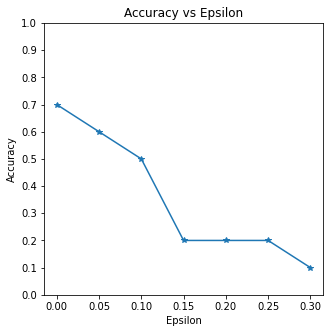

In [ ]:
print("MobileNet Model Attack Results:")
MobileNet_probset = attack(MobileNet_model)

VGG-19 Model Attack Results:
Total Time: 02:37


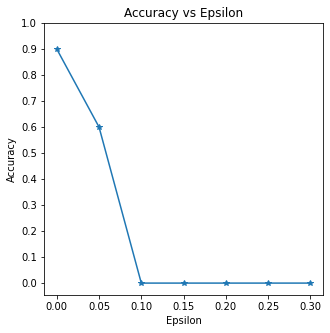

In [ ]:
print("VGG-19 Model Attack Results:")
VGG19_probset = attack(VGG19_model)

## Post Attack Predictions

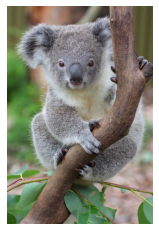

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[koala, 0.3686845898628235]","[koala, 0.665533185005188]","[koala, 0.9656147360801697]","[koala, 0.4387495517730713]"
1,0.05,"[American alligator, 0.13936632871627808]","[starfish, 0.29506275057792664]","[koala, 0.6560954451560974]","[koala, 0.08588089048862457]"
2,0.10,"[American alligator, 0.1973327249288559]","[starfish, 0.5898860096931458]","[starfish, 0.3329438269138336]","[jigsaw puzzle, 0.14368976652622223]"
3,0.15,"[coral reef, 0.3229970932006836]","[starfish, 0.5623630881309509]","[coral reef, 0.23430116474628448]","[jigsaw puzzle, 0.21353405714035034]"
4,0.20,"[coral reef, 0.3714789152145386]","[starfish, 0.48101863265037537]","[spider web, 0.33500269055366516]","[coral reef, 0.1536230891942978]"
5,0.25,"[coral reef, 0.29913976788520813]","[starfish, 0.18277956545352936]","[spider web, 0.30857527256011963]","[coral reef, 0.17329338192939758]"
6,0.30,"[coral reef, 0.2495223432779312]","[apron, 0.24450698494911194]","[spider web, 0.31779035925865173]","[stole, 0.17023494839668274]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.857143,0.857143,0.714286,0.714286


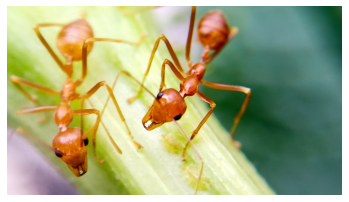

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[mantis, 0.5519078969955444]","[mantis, 0.23293741047382355]","[ant, 0.3973010778427124]","[ant, 0.48269763588905334]"
1,0.05,"[ant, 0.6917780041694641]","[walking stick, 0.21064269542694092]","[ant, 0.39728444814682007]","[ant, 0.25496572256088257]"
2,0.10,"[ant, 0.6897472143173218]","[walking stick, 0.16699112951755524]","[king crab, 0.11904294788837433]","[long-horned beetle, 0.14070892333984375]"
3,0.15,"[tick, 0.42265406250953674]","[pillow, 0.126851424574852]","[king crab, 0.21970240771770477]","[wolf spider, 0.11409667134284973]"
4,0.20,"[tick, 0.6342951059341431]","[pillow, 0.20704443752765656]","[king crab, 0.09669670462608337]","[cricket, 0.09357377141714096]"
5,0.25,"[tick, 0.668326735496521]","[pillow, 0.275502473115921]","[starfish, 0.10624781250953674]","[handkerchief, 0.1531539410352707]"
6,0.30,"[tick, 0.6550183296203613]","[pillow, 0.3604103922843933]","[envelope, 0.16497871279716492]","[handkerchief, 0.16106541454792023]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.714286,1.0,0.714286,0.714286


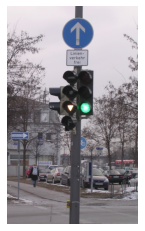

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[traffic light, 0.36916399002075195]","[quilt, 0.1407659500837326]","[traffic light, 0.9316564798355103]","[traffic light, 0.43233489990234375]"
1,0.05,"[traffic light, 0.24053888022899628]","[quilt, 0.17392504215240479]","[traffic light, 0.8773453831672668]","[traffic light, 0.3379152715206146]"
2,0.10,"[jigsaw puzzle, 0.2778812348842621]","[quilt, 0.24224089086055756]","[traffic light, 0.7595839500427246]","[jigsaw puzzle, 0.43089354038238525]"
3,0.15,"[jigsaw puzzle, 0.49827393889427185]","[quilt, 0.3296230137348175]","[traffic light, 0.5909085273742676]","[jigsaw puzzle, 0.5119010210037231]"
4,0.20,"[jigsaw puzzle, 0.5364711284637451]","[quilt, 0.38453853130340576]","[traffic light, 0.4388720393180847]","[jigsaw puzzle, 0.6939508318901062]"
5,0.25,"[jigsaw puzzle, 0.5186043381690979]","[quilt, 0.3732382357120514]","[traffic light, 0.27862676978111267]","[jigsaw puzzle, 0.8055675029754639]"
6,0.30,"[jigsaw puzzle, 0.489416241645813]","[jigsaw puzzle, 0.3920601010322571]","[jigsaw puzzle, 0.30719509720802307]","[jigsaw puzzle, 0.87030029296875]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.714286,1.0,0.142857,0.714286


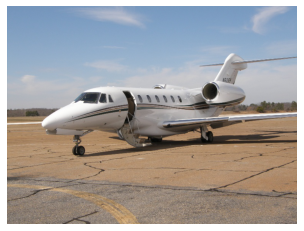

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[warplane, 0.6698194146156311]","[airship, 0.3769889771938324]","[warplane, 0.42229220271110535]","[wing, 0.5703696012496948]"
1,0.05,"[warplane, 0.3191417455673218]","[airship, 0.38279056549072266]","[warplane, 0.4114247262477875]","[wing, 0.420350044965744]"
2,0.10,"[sundial, 0.32093632221221924]","[airship, 0.24557407200336456]","[airliner, 0.3075571358203888]","[sundial, 0.22105827927589417]"
3,0.15,"[sundial, 0.1464354544878006]","[maze, 0.151655912399292]","[tray, 0.0740400180220604]","[sundial, 0.398714542388916]"
4,0.20,"[envelope, 0.16873057186603546]","[maze, 0.17068563401699066]","[envelope, 0.1409156769514084]","[sundial, 0.10312303155660629]"
5,0.25,"[envelope, 0.30159807205200195]","[maze, 0.1778034269809723]","[envelope, 0.1381916105747223]","[jigsaw puzzle, 0.08551117777824402]"
6,0.30,"[envelope, 0.340969055891037]","[maze, 0.1481933295726776]","[envelope, 0.1282367706298828]","[jigsaw puzzle, 0.12088193744421005]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,1.0,1.0,0.857143,1.0


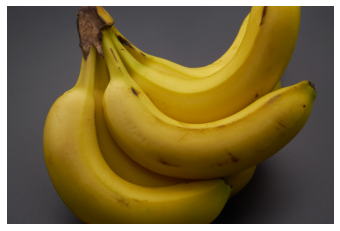

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[banana, 0.64804607629776]","[nematode, 0.06835050135850906]","[banana, 0.992638111114502]","[banana, 0.34022411704063416]"
1,0.05,"[banana, 0.505563497543335]","[nematode, 0.12425055354833603]","[banana, 0.9940645098686218]","[pitcher, 0.25790470838546753]"
2,0.10,"[banana, 0.3471890091896057]","[nematode, 0.24154512584209442]","[banana, 0.7769860625267029]","[nematode, 0.12036772817373276]"
3,0.15,"[nematode, 0.3637293875217438]","[nematode, 0.2631685733795166]","[sock, 0.1603187918663025]","[bib, 0.17015884816646576]"
4,0.20,"[nematode, 0.4401503801345825]","[nematode, 0.34449803829193115]","[stole, 0.17783072590827942]","[brassiere, 0.19250249862670898]"
5,0.25,"[nematode, 0.4629930555820465]","[nematode, 0.339695006608963]","[stole, 0.16004343330860138]","[brassiere, 0.22071966528892517]"
6,0.30,"[nematode, 0.4496171474456787]","[bib, 0.37205031514167786]","[stole, 0.1569090187549591]","[brassiere, 0.2328854352235794]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.571429,1.0,0.571429,0.857143


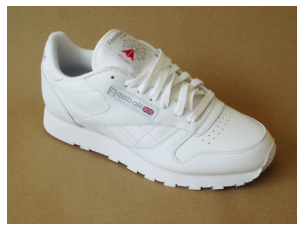

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[running shoe, 0.4477757215499878]","[handkerchief, 0.274997353553772]","[clog, 0.30631542205810547]","[running shoe, 0.39891964197158813]"
1,0.05,"[running shoe, 0.4955798089504242]","[handkerchief, 0.3369199335575104]","[clog, 0.29819798469543457]","[bib, 0.5483061075210571]"
2,0.10,"[envelope, 0.45185381174087524]","[handkerchief, 0.470371276140213]","[sock, 0.22169703245162964]","[bib, 0.4192725121974945]"
3,0.15,"[envelope, 0.4898567497730255]","[handkerchief, 0.5820620059967041]","[sock, 0.25062844157218933]","[bib, 0.28310754895210266]"
4,0.20,"[envelope, 0.4458153247833252]","[handkerchief, 0.6385773420333862]","[sock, 0.2592112421989441]","[bib, 0.2357892394065857]"
5,0.25,"[envelope, 0.41892707347869873]","[handkerchief, 0.6545563340187073]","[sock, 0.24292130768299103]","[bib, 0.19887781143188477]"
6,0.30,"[envelope, 0.3408820629119873]","[handkerchief, 0.6828169226646423]","[sock, 0.1835830807685852]","[bib, 0.15628685057163239]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.714286,1.0,1.0,0.857143


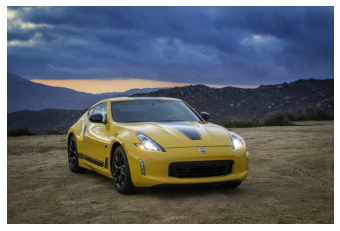

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[sports car, 0.4678507447242737]","[bubble, 0.23086108267307281]","[sports car, 0.3432031571865082]","[sports car, 0.7368323802947998]"
1,0.05,"[sports car, 0.34711095690727234]","[bubble, 0.21420499682426453]","[convertible, 0.22549769282341003]","[sports car, 0.6011521220207214]"
2,0.10,"[soccer ball, 0.2067657709121704]","[bubble, 0.14222081005573273]","[convertible, 0.43041351437568665]","[racer, 0.3598782420158386]"
3,0.15,"[soccer ball, 0.19807688891887665]","[gar, 0.3036130964756012]","[convertible, 0.0835086852312088]","[racer, 0.14627763628959656]"
4,0.20,"[Arabian camel, 0.12209004908800125]","[gar, 0.30408141016960144]","[studio couch, 0.1490037739276886]","[purse, 0.26715323328971863]"
5,0.25,"[Arabian camel, 0.14279109239578247]","[nematode, 0.266267865896225]","[quilt, 0.18393874168395996]","[purse, 0.21796296536922455]"
6,0.30,"[Arabian camel, 0.11594020575284958]","[nematode, 0.4624157249927521]","[quilt, 0.1185229942202568]","[purse, 0.1910962462425232]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.714286,1.0,0.857143,0.714286


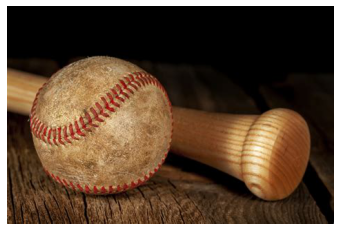

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[chiton, 0.9138961434364319]","[acorn, 0.11222616583108902]","[baseball, 0.9937856197357178]","[baseball, 0.6686257123947144]"
1,0.05,"[chiton, 0.9233598709106445]","[chiton, 0.12321172654628754]","[baseball, 0.989388108253479]","[baseball, 0.45573556423187256]"
2,0.10,"[chiton, 0.8443182110786438]","[chiton, 0.12628641724586487]","[baseball, 0.954681396484375]","[chiton, 0.5276485085487366]"
3,0.15,"[chiton, 0.7309108376502991]","[mitten, 0.11393753439188004]","[baseball, 0.7321724891662598]","[sea urchin, 0.5588594079017639]"
4,0.20,"[chiton, 0.6166865825653076]","[mitten, 0.13633842766284943]","[baseball, 0.5025249123573303]","[sea urchin, 0.7852613925933838]"
5,0.25,"[brain coral, 0.3718554675579071]","[bonnet, 0.15049707889556885]","[baseball, 0.2878824472427368]","[sea urchin, 0.8591041564941406]"
6,0.30,"[brain coral, 0.5103564858436584]","[bonnet, 0.14311665296554565]","[baseball, 0.09750331193208694]","[sea urchin, 0.9173948168754578]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,1.0,1.0,0.0,0.714286


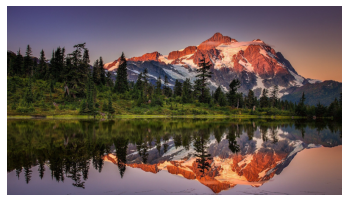

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[alp, 0.2781967222690582]","[gar, 0.16627198457717896]","[volcano, 0.15991008281707764]","[alp, 0.5848208665847778]"
1,0.05,"[American alligator, 0.2677760124206543]","[gar, 0.1925642043352127]","[volcano, 0.06120200455188751]","[alp, 0.31148582696914673]"
2,0.10,"[American alligator, 0.31273797154426575]","[gar, 0.2790505886077881]","[jigsaw puzzle, 0.17490503191947937]","[jigsaw puzzle, 0.25815507769584656]"
3,0.15,"[jigsaw puzzle, 0.2457566112279892]","[gar, 0.42753782868385315]","[jigsaw puzzle, 0.28956031799316406]","[jigsaw puzzle, 0.3397732377052307]"
4,0.20,"[jigsaw puzzle, 0.3874298930168152]","[gar, 0.4611775875091553]","[jigsaw puzzle, 0.2957635819911957]","[jigsaw puzzle, 0.46702492237091064]"
5,0.25,"[jigsaw puzzle, 0.4598647952079773]","[gar, 0.3541135787963867]","[jigsaw puzzle, 0.14410614967346191]","[jigsaw puzzle, 0.6605815887451172]"
6,0.30,"[jigsaw puzzle, 0.49575909972190857]","[gar, 0.24853473901748657]","[envelope, 0.17553015053272247]","[jigsaw puzzle, 0.7566424608230591]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.857143,1.0,1.0,0.714286


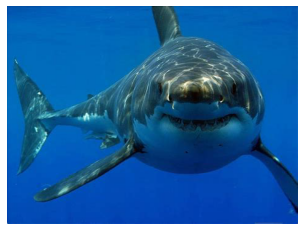

Top Probabilities:


,Epsilons,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.00,"[great white shark, 0.46524378657341003]","[bubble, 0.3670601546764374]","[great white shark, 0.38636985421180725]","[great white shark, 0.35445600748062134]"
1,0.05,"[great white shark, 0.2168862223625183]","[jellyfish, 0.32074326276779175]","[great white shark, 0.38996750116348267]","[electric ray, 0.27529987692832947]"
2,0.10,"[electric ray, 0.1589571088552475]","[jellyfish, 0.4687460958957672]","[great white shark, 0.1990298479795456]","[electric ray, 0.4607880115509033]"
3,0.15,"[electric ray, 0.16724050045013428]","[jellyfish, 0.5828574299812317]","[ladle, 0.10434707999229431]","[electric ray, 0.4301261901855469]"
4,0.20,"[electric ray, 0.1588325947523117]","[jellyfish, 0.5842189788818359]","[electric ray, 0.10781636089086533]","[jellyfish, 0.525424599647522]"
5,0.25,"[electric ray, 0.15213130414485931]","[jellyfish, 0.5098288059234619]","[electric ray, 0.15576767921447754]","[jellyfish, 0.6025513410568237]"
6,0.30,"[electric ray, 0.12887731194496155]","[jellyfish, 0.3694232702255249]","[leatherback turtle, 0.12567903101444244]","[jellyfish, 0.7654380202293396]"


Attack Success Rates:


,ResNet-18 Model,AlexNet Model,MobileNet Model,VGG-19 Model
0,0.714286,1.0,0.571429,0.857143


In [ ]:
def eplist(model_list,imgdex):
  eplist = []
  for i in range(len(epsilons)):
    eplist.append((model_list[i])[imgdex])
  return eplist

def succ(problist,initlist,i):
  corr = 0
  initID = (initlist[i])[0]
  for id,prob in problist:
    if id != initID:
      corr = corr+1
  return corr/len(problist)

for i in range(len(imgset)):
  plt.imshow((imgset[i])[0])
  plt.grid('off')
  plt.axis('off')
  plt.show()
  
  Rprobs = eplist(ResNet_probset,i)
  Aprobs = eplist(AlexNet_probset,i)
  Mprobs = eplist(MobileNet_probset,i)
  Vprobs = eplist(VGG19_probset,i)

  print('Top Probabilities:')
  df = pd.DataFrame({'Epsilons' : epsilons,
                    'ResNet-18 Model' : Rprobs,
                     'AlexNet Model' : Aprobs,
                     'MobileNet Model' : Mprobs,
                     'VGG-19 Model' : Vprobs
  })
  display(df)
  print('Attack Success Rates:')
  display(pd.DataFrame({
                    'ResNet-18 Model' : [succ(Rprobs,initrespred,i)],
                     'AlexNet Model' : [succ(Aprobs,initalexpred,i)],
                     'MobileNet Model' : [succ(Mprobs,initmobilepred,i)],
                     'VGG-19 Model' : [succ(Vprobs,initvggpred,i)]
  }))
